<h1>Capsnet: "Dynamic Routing Between Capsules"</h1>
<h4><span style="text-decoration: underline;">Original Paper:</span> Geoffrey E. Hinton,&nbsp;Sara Sabour,&nbsp; Nicholas Frosst</h4>
<h4><span style="text-decoration: underline;">Notebook Author:</span>&nbsp; Brandon Lwowski</h4>

<h2>I. Introduction</h2>
<p>Geoffrey Hinton and his colleagues developed a new architecture for neural nets, called Capsule Networks, to tackle some of the negative issues present with the traditional CNN. The Convolutional Neural Network is commonly used in tasks such as computer vision and text classification. VGG-16, Inception, and ResNet-50 are all architectures that are extremely successful in the domain of computer vision and all use multiple convolutional layers in their networks.</p>
<p>Even with the large amount of success that CNN's have earned, there are drawbacks present that limit their overall ability. CNN's do not store spatial or orientational relationships between features. The most common example is the human face. As long as the image has 2 eyes, a nose, and a mouth, the CNN will classify it a face, regardless of if the mouth is above the eyes, or the nose is by the ears.&nbsp;</p>
<p>The Capsule Network was Hinton&rsquo;s attempt to fix these known issues of CNN's. The "capsules" in this architecture learn spatial and orientational features, which will be discussed later in this notebook. In this notebook you will see my implementation of a Capsule Network on the MNIST data set. The network is trained on data that has not been augmented and tested on images that have been scaled and rotated. You will see that the CapsNet does well on the scaled data but, still struggles to solve the rotational invariance issue with traditional CNNs.</p>
<img src = "./images/capsnet.png">
<h2>II. Background</h2>
<p>&nbsp;</p>
<p>What are Capsules? You can find a detailed explanation in Hinton&rsquo;s first paper "<a href="http://www.cs.toronto.edu/~fritz/absps/transauto6.pdf">Transforming Auto-encoders</a>" but I will do my best to paraphrase here. A capsule is a set of neurons that produce a vector. This differs from a typical neural network, where the output is a scalar. This vector can represent the size, orientation, or even the hue of the image once trained.</p>
<p>&nbsp;</p>
<img src = "./images/capsule.png">
<p>In the image above you will see 2 different types of capsules. The red capsules are created using 3 neurons and the green capsules are created using 4 neurons. The red capsules are used as recognition units and the green capsules are used as generation units (This will be discussed further down in the notebook).&nbsp; Recognition units, similar to the hidden later in a general artificial neural network, are used to compute the X-position, Y-position and the probability that the visual feature is present in the input image. The generation units receive the X-position plus the change in X and the Y-position plus the change in Y and then are multiplied by the probability to generate the actual output. The distance between the actual output and target output are then calculated and used to adjust the capsules weights. By multiplying the output of the generation units by the probability, inactive capsules will not affect the actual output.</p>

<h2>III. Implementation</h2>
<p>Below you will find my pytorch implementation of capsule networks and the dynamic routing algorithm provided by Hinton.&nbsp;</p>

In [1]:
### Import Libraries

### pytorch libraries needed
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np               ### Matrix Math
import matplotlib.pyplot as plt  ### Data visualizations

from tqdm import tqdm            ### Create progress bar
import gc                        ### Garbage collect to save memory

In [2]:
### Hyperparameters
USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 128
N_EPOCHS = 30            
LEARNING_RATE = 0.0001
MOMENTUM = 0.7

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
gc.collect()

55

<h2>III(a). Data and Data Analysis</h2>
<p>The following four functions are used to create train and test data. For this experiment of the capsule network, I plan to train the model on data that has not been augmented. It will be trained on the original 29x29 MNIST data set. The goal of this notebook is to investigate how well the model can classify MNIST data that has been rotated or scaled. The <font face="courier">test_loader</font> is a base line; these images are not augmented.  <font face="courier">test_loader_rotate</font> is a test set of MNIST images randomly rotated -75 degrees to 75 degrees. Lastly, the  <font face="courier">test_loader_scale_half</font> was resized, so the image is half the size and padded to match the 28x28 dimensions. Below those 4 functions you will find examples of training set, test set original, test set rotated, and test set scaled&nbsp;</p>
<img src = "./images/MNIST.png">


In [4]:
### Get MNIST Data

#train = True pulls from training set train = False pulls from testing data
#Compose() chains multiple transformations together
#ToTensor() transforms PIL image or numpy array to torch tensor
#Normalize() normalize a tensor image with mean and standard deviation (mean, std)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader_rotate = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.RandomRotation((-75,75)),
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader_scale_half = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                transforms.Resize(20),
                                transforms.Pad(padding=4, padding_mode='edge'),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

Index: 0
Example Shape: torch.Size([128, 1, 28, 28])
Target Shape : torch.Size([128])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

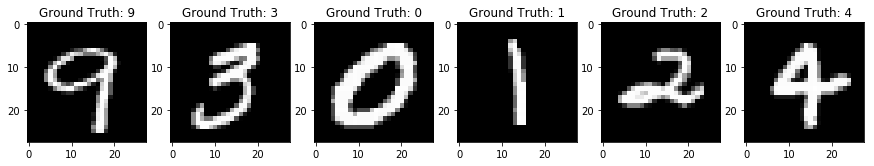

In [5]:
### Train Data
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

Index: 0
Example Shape: torch.Size([128, 1, 28, 28])
Target Shape : torch.Size([128])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

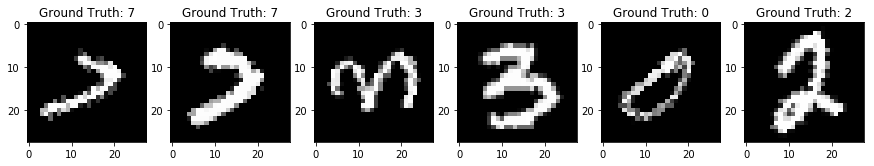

In [6]:
### Test Data Rotate
examples = enumerate(test_loader_rotate)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

Index: 0
Example Shape: torch.Size([128, 1, 28, 28])
Target Shape : torch.Size([128])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

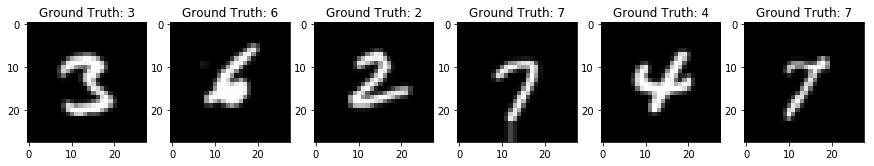

In [7]:
### Test Data Scale
examples = enumerate(test_loader_scale_half)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

In [8]:
gc.collect()

20700

<h2>III(b). Design</h2>
<p>The topology of a Capsule Network has 4 major components that make up the CapsNet architecture. The convolutional layer, primary caps layer, digit caps layer, and the decoder.&nbsp; Each of the 4 components will have a detailed explanation further down in the notebook.&nbsp;</p>
<p>In order to discuss how the CapsNet works, it is important to understand the Hinton&rsquo;s new activation function, called the squash function, the loss function for the CapsNet, and the Dynamic Routing algorithm used in his paper.</p>
<p>Below you will find the equation created by Hinton called the squash function. Typically, in CNNs, you will see activation functions like relu in order to create non-linearity in the network. The objective of the squash function is to take a vector as an input and "squash" it to have a length of no more than 1. By squashing the vector, it can now be interpreted as a probability that the feature is present in the image.</p>
<p>Looking at the formula it is key to note that the subscript 'j' represents capsule j and s <sub>j</sub> is the input vector.&nbsp;</p>
<img src = "./images/squash.png">

In [9]:
def squash(s_j):
    squared_norm = (s_j ** 2).sum(-1, keepdim=True)
    v_j = squared_norm * s_j / ((1. + squared_norm) * torch.sqrt(squared_norm))
    return v_j

### Margin Loss from CapsNet Paper

<img src = "./images/marginloss.JPG">

<p>The next important part of the CapsNet to discuss is the loss function used by Hinton in his paper. He calls it the "margin loss for digit existence". In order to understand this complicated equation, it is easier to break it into pieces. What the margin loss function is trying to do is calculate the loss for every class "k". The term L<sub>k</sub>is the calculated loss for class k. The losses for each k will be summed and averaged to calculate the final loss for the current batch.&nbsp;</p>
<p>The next import part of the equation in T<sub>k</sub>.   T<sub>k</sub> is the correct label for the input v<sub>k</sub>. T<sub>k</sub> will always equal 1 if DigitCap is correct and will equal 0 when it is incorrect.&nbsp;</p>
<p>The max functions can be defined as relu activations. The max function on the left will produce a 0 loss when the prediction has a greater probability than 0.9 and the max function on the right will produce a 0 loss with a probability less than 0.1.&nbsp;</p>
<p>The last piece to discuss it the lambda times 1 - T<sub>c</sub>. When T<sub>c</sub> is correct then the entire expression goes to 0. When T<sub>c</sub> is incorrect the expression goes to lambda. In Hinton&rsquo;s implementation, he uses a lambda value of 0.5.&nbsp;</p>
<p>To simplify the equation, the left side of the equation will be calculated if the prediction is correct and the right side of the equation will be calculated if the prediction is incorrect.</p>

In [10]:
def margin_loss(v_k, T_k, size_average=True):
        #v_k shape = [batch_size, number of digits, length of digit caps, 1 batch]
        batch_size = v_k.size(0)
        
        # get the norm of v_k
        v_k_norm = torch.sqrt((v_k ** 2).sum(dim=2, keepdim=True))
        
        # 0.9 is given for m+ and 0.1 is given for m- from the Dynamic Routing paper 
        left = F.relu(0.9 - v_k_norm).view(batch_size, -1)
        right = F.relu(v_k_norm - 0.1).view(batch_size, -1)
        
        # 0.5 is given for lamda from the Dynamic Routing paper
        loss = T_k * left + 0.5 * (1.0 - T_k) * right
        loss = loss.sum(dim=1).mean()

        return loss

### Layer 1 = Convolutional Layer
<p><img src = "./images/capsnet_conv.png"></p>

<p>This is the commonly used convolutional layer present in CNN's. The Input to the Conv Layer is a 28x28 MNIST number. A 256 kernels of size 9 are moved across the image and passed through the ReLU activation function. The output a 256 20x20 images that have been convolved.</p>
<p>Input = 28x28 image (one color channel)</p>
<p>Number of Kernals = 256</p>
<p>Kernal Size = 9x9</p>
<p>Stride = 1</p>
<p>Output = 20x20x256</p>

In [19]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))

### Layer 2 = Primary Caps Layer
<p><img src = "./images/capsnet_PC.png"></p>
<p>This is the first layer of capsules. The capsules primary job is to learn patterns between the features found in the convolution layer before. In the architecture provided by Hinton, this layer has 32 capsules of size 6x6x8. The operation is very similar to a 3d convolutional layer. A kernel of 9X9X256 is moves across the capsules, but instead of max pooling like a traditional CNN, the squash activation is applied.</p>
<p>Input = 20x20x256 tensor</p>
<p> Number of Capsules = 32</p>
<p>Kernal Size = 9x9x256</p>
<p>Stride = 2</p>
<p>Output = 6x6x8x32 tensor</p>

In [21]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.num_routes, -1)
        return squash(u)

### Layer 3 = Digit Caps Layer
<p><img src = "./images/capsnet_DC.png"></p>
<p>This is the second layer of capsules. Each row in the DigitCaps layer represents a capsule for the current class. In our case, on capsule for every number 0-9. The DigitCaps layer receives the 6x6x8x32 output from the PrimaryCaps layer.</p>
<p>Input = 6x6x8x32 tensor</p>
<p>Number of Capsules = 10 </p>

<p>Output = 16x10 matrix</p>
<p>The following routing algorithm is provided by Hinton in his paper</p>
<p><img src = "./images/algo.JPG"></p>

In [22]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, u_i):
        ### Routing algorithm
        batch_size = u_i.size(0)
        
        ### Calculate u_hat in order to calculate s_j
        ### u_i is the output of the capsules
        ### W is the weight matrix
        ### u_hat is weight matrix mutliplied by the output u_i
        u_i = torch.stack([u_i] * self.num_capsules, dim=2).unsqueeze(4)
        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, u_i)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        ### Loop through number of routing interations
        routing_iterations = 3
        for iteration in range(routing_iterations): ### line 3
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4) ### line 4

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)  ### line 5
            v_j = squash(s_j)  ### line 6

            if iteration < routing_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)   ### line 7

        return v_j.squeeze(1)


### Decoder
<p>Input =&nbsp;16-dimensional vector from the Digit Capsule Layer</p>
<p>Output = 28x28 reconstructed image</p>
<p>Loss Function =&nbsp;&nbsp;Euclidean distance between the reconstructed image and the input image&nbsp;</p>

### Layer 4 = Fully Connected 1
<p>Input =&nbsp;16x10 flattened (160 nodes)</p>
<p>Output = 512 nodes</p>

### Layer 5 = Fully Connected 2
<p>Input 512 nodes</p>
<p>Output = 1024 nodes</p>

### Layer 6 = Fully Connected 3
<p>Input 1024 nodes</p>
<p>Output = 784 nodes (28x28)</p>

<p><img src = "./images/decoder.png"></p>

In [24]:
class Decoder(nn.Module):
    def __init__(self, input_width=28, input_height=28, input_channel=1):
        super(Decoder, self).__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.input_channel = input_channel
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, self.input_height * self.input_height * self.input_channel),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        t = (x * masked[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(t)
        reconstructions = reconstructions.view(-1, self.input_channel, self.input_width, self.input_height)
        return reconstructions, masked

In [25]:
gc.collect()

172

# Construct Entire Capsule Network Model

In [26]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)


    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

# Train and Test Loops for the Model

In [27]:
def train(model, optimizer, train_loader, epoch):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        train_loss = loss.data
        total_loss += train_loss
        if batch_id % 100 == 0:
            tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                epoch,
                N_EPOCHS,
                batch_id + 1,
                n_batch,
                correct / float(BATCH_SIZE),
                train_loss / float(BATCH_SIZE)
                ))
    tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,N_EPOCHS,total_loss / len(train_loader.dataset)))
    
def test(capsule_net, test_loader, epoch, name):
    capsule_net.eval()
    test_loss = 0
    correct = 0
    for batch_id, (data, target) in enumerate(test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))

    tqdm.write(
        "Epoch: [{}/{}], test accuracy {}: {:.6f}, loss: {:.6f}".format(epoch, N_EPOCHS, str(name), correct / len(test_loader.dataset),
                                                                  test_loss / len(test_loader)))


# Run the Training

In [28]:
gc.collect()
capsule_net = CapsNet()

if USE_CUDA:
    capsule_net = capsule_net.cuda()

optimizer = torch.optim.Adam(capsule_net.parameters())

for e in range(1, N_EPOCHS + 1):
    train(capsule_net, optimizer, train_loader, e)
    test(capsule_net, test_loader, e, "NORMAL TEST")
    test(capsule_net, test_loader_rotate, e, "ROTATED TEST")
    test(capsule_net, test_loader_scale_half, e, "SCALE TEST")


torch.save(capsule_net.state_dict(), './capsnet_trained.model')



KeyboardInterrupt: 

<h2>Sources</h2>
<p>1.&nbsp;<a href="https://arxiv.org/pdf/1710.09829.pdf">Dynamic Routing Between Capsules</a>&nbsp;</p>
<p>2. <a href="https://openreview.net/pdf?id=HJWLfGWRb">Matrix Capsules with EM Routing</a></p>
<p>3.&nbsp;<a href="http://www.cs.toronto.edu/~fritz/absps/transauto6.pdf">Transforming Auto-encoders</a></p>
<p>&nbsp;</p>
<p>&nbsp;</p>